# Lane Detection

車道偵測  
車道偵測是當前影像處理的一個強大應用  
車道偵測對於自駕車的發展有著非常重要的地位  

## Image

首先匯入被處理圖  
並對其resize  
原本的解析度太高  
在做運算的時候會格外的耗費資源  

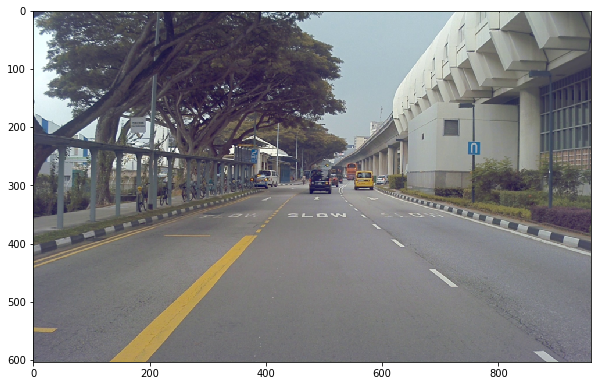

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


img = cv2.imread('lane.jpg')
img = cv2.pyrDown(img)

width = img.shape[1]
height = img.shape[0]

plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])

## Perspective

由於影像中太多的不必要資訊  
對於道路偵測，只須著重在圖中的道路區塊做處理  
在這裡利用透視變換做轉置取得ROI

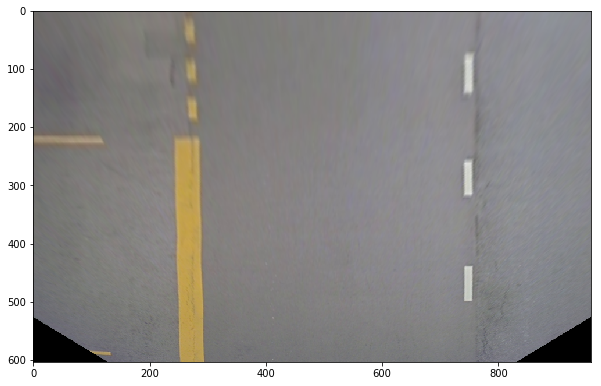

In [3]:
def getPerspectiveMatrix(reverse=False,img=None):
    tls = (325,375)  # top left source point
    bls = (150,475)  # bottom left source point
    tld = (120,145)  # top left destination 
    bld = (120,500)  # bottm left destination 
    src = np.float32([[tls[0], tls[1]], [width-tls[0], tls[1]],
                      [width-bls[0], bls[1]],[bls[0], bls[1]]])
             
    dst = np.float32([[tld[0], tld[1]], [width-tld[0], tld[1]],
                      [width-tld[0], bld[1]], [bld[0], bld[1]],])
    if reverse:
        M = cv2.getPerspectiveTransform(dst,src) 
    else: 
        M = cv2.getPerspectiveTransform(src,dst)
    return M
    
def pespectiveimg(img,Persp_M,reverse = False):
    wraped = cv2.warpPerspective(img,Persp_M,(width,height),cv2.INTER_LINEAR)
    return wraped

Persp_M =  getPerspectiveMatrix(False)

wraped = pespectiveimg(img,Persp_M)

plt.figure(figsize=(10,10))
plt.imshow(wraped[:,:,::-1])

## Color space transform

取邊運算  
首先評估影像拆成HSV  
比起RGB能更好的解析出線條

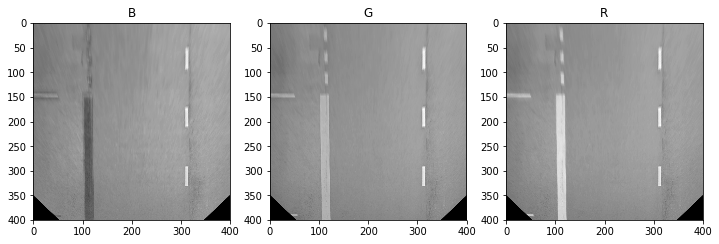

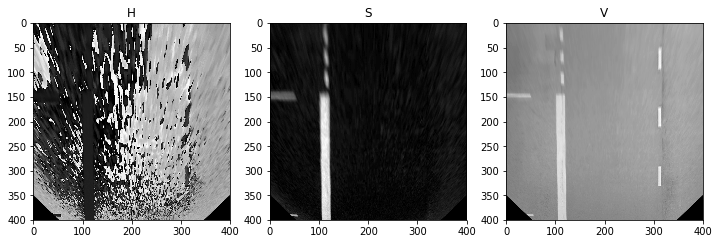

In [4]:
def plot3channel(img,title):
    reimg= cv2.resize(img,(400,400))
    title = title.split('.',-1)
    plt.figure(figsize=(12,4))
    plt.subplot(131),plt.imshow(reimg[:,:,0],'gray'),plt.title(title[0])
    plt.subplot(132),plt.imshow(reimg[:,:,1],'gray'),plt.title(title[1])
    plt.subplot(133),plt.imshow(reimg[:,:,2],'gray'),plt.title(title[2])

wraped_HSV = cv2.cvtColor(wraped,cv2.COLOR_BGR2HSV)

plot3channel(wraped,'B.G.R')
plot3channel(wraped_HSV,'H.S.V')

# Edge detection

利用Sobel先取得影像的邊緣  
另外利用侵蝕與膨脹把雜訊清除  

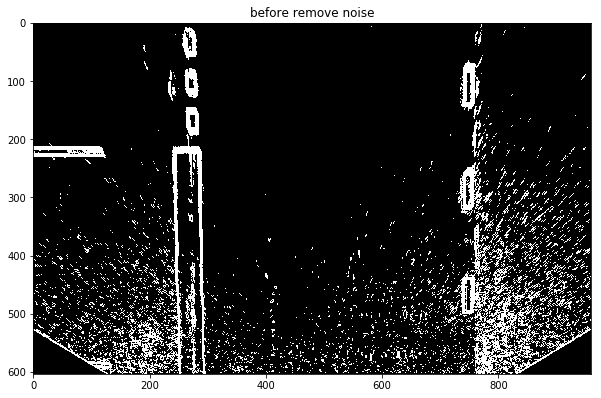

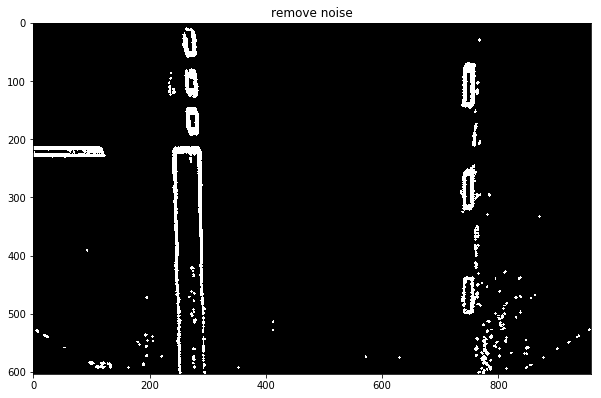

In [5]:
def get_edge_and_denoise(img):
    # sobel edge detevtion
    x = cv2.Sobel(img,cv2.CV_16S,1,0)
    y = cv2.Sobel(img,cv2.CV_16S,0,1)
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)
    res = cv2.addWeighted(absX,0.5,absY,0.5,0)
    otsu1, res_theshould = cv2.threshold(res, 10, 255, cv2.THRESH_BINARY)
    plt.figure(figsize=(10,10)),plt.imshow(res_theshould,'gray'),plt.title('before remove noise')
    
    # using Morphology to remove noise
    kernel = cv2.getStructuringElement(1,(3,3))
    res_theshould = cv2.erode(res_theshould,kernel,iterations=2)
    res_theshould = cv2.dilate(res_theshould,kernel,iterations=2)
    plt.figure(figsize=(10,10)),plt.imshow(res_theshould,'gray'),plt.title('remove noise') 
    return res_theshould

wrapedV_edge = get_edge_and_denoise(wraped_HSV[:,:,2])

## Line detection

利用HoughLinesP來取得直線線段點座標  
因為圖上勢必會取得很多不符合斜率的座標  
於是必須先把座標不合的結果替除掉  
最後用Naive的方法把座標分成左線與右線的部分  
取得X的中位數以後，直接畫出來

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


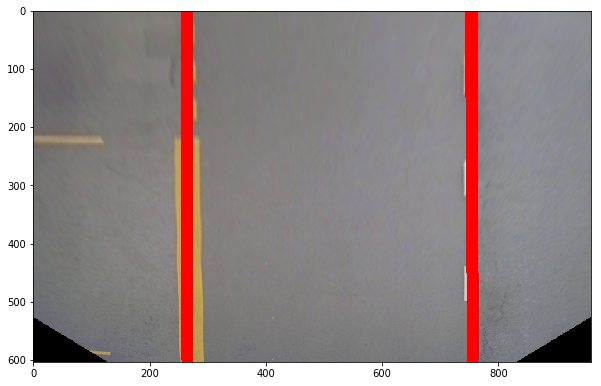

In [6]:
def get_LeftandRight_line(img):
    lines = cv2.HoughLinesP(img,1,np.pi/270,120,minLineLength=15,maxLineGap=20)
    if lines is not None:
        line = lines[:,0,:]
        return line
    return None

def get_LeftRight_line_coordinate(line):
    slope = (line[:,1]-line[:,3])/(line[:,0]-line[:,2])
    slope=slope.reshape((len(slope),1))    
    slope=np.concatenate((slope,line),axis=1).astype('int32')
    left_line, right_line=[],[]
    for s,x1,y1,x2,y2 in slope:
        if abs(s)>8:
            if x1 < 450: 
                left_line.append([x1,y1,x2,y2])
            else:
                right_line.append([x1,y1,x2,y2])
    left_line = np.array(left_line)
    right_line = np.array(right_line)
    return left_line, right_line


def print_line(img,line):
    if line is None:
        return
    left_lines, right_lines  = get_LeftRight_line_coordinate(line)

    if len(left_lines)>0:
        left_points_1 = (np.median(left_lines[:,0]).astype('int32'),0)
        left_points_2 = (np.median(left_lines[:,2]).astype('int32'),600)
        cv2.line(img, left_points_1, left_points_2, (0,0,255),20)
    if len(right_lines)>0:
        right_points_1 = (np.median(right_lines[:,0]).astype('int32'),0)
        right_points_2 = (np.median(right_lines[:,2]).astype('int32'),600)
        cv2.line(img, right_points_1, right_points_2, (0,0,255),20)
        
line = get_LeftandRight_line(wrapedV_edge)
print_line(wraped,line)

plt.figure(figsize=(10,10))
plt.imshow(wraped[:,:,::-1])

# pespective back to origin image

接下來利用一個畫了線的Mask  
逆投射回去原圖的平面  
再利用Add mask的方式加上去就完成了

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


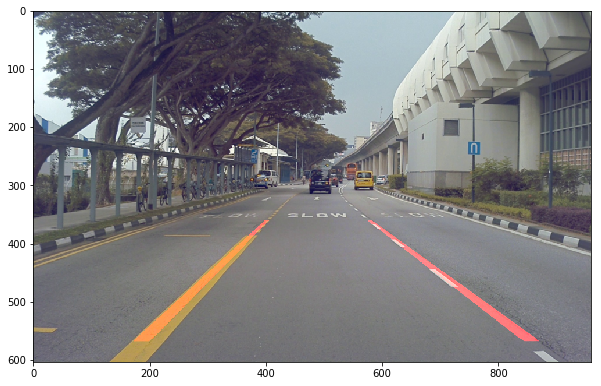

In [7]:
cp = np.zeros_like(wraped)
print_line(cp,line)

Persp_M_Inv =  getPerspectiveMatrix(True)
cp_result= pespectiveimg(cp,Persp_M_Inv,True)
result = cv2.addWeighted(img, 1.0, cp_result, 0.8, 0)

plt.figure(figsize=(10,10))
plt.imshow(result[:,:,::-1])

## Summary

這個算法目前應用在高速公路上的直線比較沒問題  
 
在平面道路上仍有許多待克服  
1. 地上的標記線會偵測到許多的線條
2. 在彎道處的偵測